In [1]:

import os

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import xarray as xr

import cartopy.crs as ccrs

# import the GRS package suite
import GRSdriver
import grs 
#import grstbx

print(f'-GRSdriver: {GRSdriver.__version__}')
print(f'-grs: {grs.__version__}')
#print(f'-grstbx: {grstbx.__version__}')

-GRSdriver: 1.0.3
-grs: 2.1.6


In [2]:


file = '/data/satellite/Sentinel-2/L1C/30PYT/2018/10/19/S2A_MSIL1C_20181019T102031_N0500_R065_T30PYT_20230815T043850.SAFE'

tile = file.split('_')[-2][1:]
dem_file = '/home/harmel/Dropbox/Dropbox/satellite/dem/COP-DEM_GLO-30-DGED_'+tile+'.tif'
cams_file = '/data/cams/world/cams_forecast_2018-10.nc'

In [3]:
process_ = grs.Process()
process_.execute(file,
            cams_file=cams_file,
            resolution=20,
            surfwater_file=None,
            dem_file=dem_file,
            scale_aot=1,
            opac_model='DESE_rh70')

INFO:root:Open raw image and compute angle parameters


/home/harmel/anaconda3/envs/grstbx/lib/python3.9/site-packages/xarray/core/indexes.py:659: RuntimeWarning: '<' not supported between instances of 'SpectralBandNames' and 'SpectralBandNames', sort order is undefined for incomparable objects.
  new_pd_index = pd_indexes[0].append(pd_indexes[1:])


INFO:root:pass raw image as grs product object


INFO:root:get CAMS auxilliary data


INFO:root:flagging from l1c data


INFO:root:cloud masking with s2cloudless


INFO:root:land masking


INFO:root:cirrus masking


INFO:root:high swir masking


INFO:root:loading look-up tables


INFO:root:compute gaseous transmittance from cams data


INFO:root:correct for gaseous absorption


INFO:root:compute spectral index (e.g., NDWI)


INFO:root:apply water masking


INFO:root:lut interpolation


INFO:root:selected aerosol model: DESE_rh70


INFO:root:scaling aot by: 1


INFO:root:set final parameters


INFO:root:compute surface pressure from dem


INFO:root:run grs process


INFO:root:success


INFO:root:construct final product


INFO:root:construct l2a


In [4]:
process_.l2a.l2_prod


<xarray.Dataset>
Dimensions:      (wl: 11, y: 5490, x: 5490)
Coordinates:
  * wl           (wl) int64 443 490 560 665 705 740 783 842 865 1610 2190
    time         datetime64[ns] 2018-10-19T10:20:31
  * x            (x) float64 7e+05 7e+05 7e+05 ... 8.097e+05 8.097e+05 8.098e+05
  * y            (y) float64 1.3e+06 1.3e+06 1.3e+06 ... 1.19e+06 1.19e+06
    band         int64 1
    spatial_ref  int64 0
Data variables:
    Rrs          (wl, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    BRDFg        (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    aot550       (y, x) float32 0.185 0.185 0.185 0.185 ... 0.1989 0.1989 0.1989
    vza          (y, x) float32 8.844 8.844 8.84 8.84 ... 2.088 2.091 2.091
    sza          (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    raa          (y, x) float64 313.3 313.3 313.2 313.2 ... 118.2 118.4 118.4
    flags_l1c    (y, x) int64 184 184 184 184 184 184 ... 120 120 120 120 120
    dem          (y, x) float32 308.6 308.5 308.7 308.9 ... 232.8 232.9 233.0
    surfwater    (y, x) int8 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
Attributes: (12/68)
    long_name:                           CA BLUE GREEN RED VRE_1 VRE_2 VRE_3 ...
    constellation:                       Sentinel-2
    constellation_id:                    S2
    product_path:                        /data/satellite/Sentinel-2/L1C/30PYT...
    product_name:                        S2A_MSIL1C_20181019T102031_N0500_R06...
    product_filename:                    S2A_MSIL1C_20181019T102031_N0500_R06...
    ...                                  ...
    ndwi_threshold:                      0.0
    vis_swir_index_threshold:            0.0
    hcld_threshold:                      0.003
    dirdata:                             /data/grs/grsdata
    abs_gas_file:                        /home/harmel/anaconda3/envs/grstbx/l...
    water_vapor_transmittance_file:      /home/harmel/anaconda3/envs/grstbx/l...

In [5]:
process_.ofile='/data/satellite/grs_v21_test_image'
process_.write_output()

INFO:root:export final product into netcdf


INFO:root:export into encoded netcdf


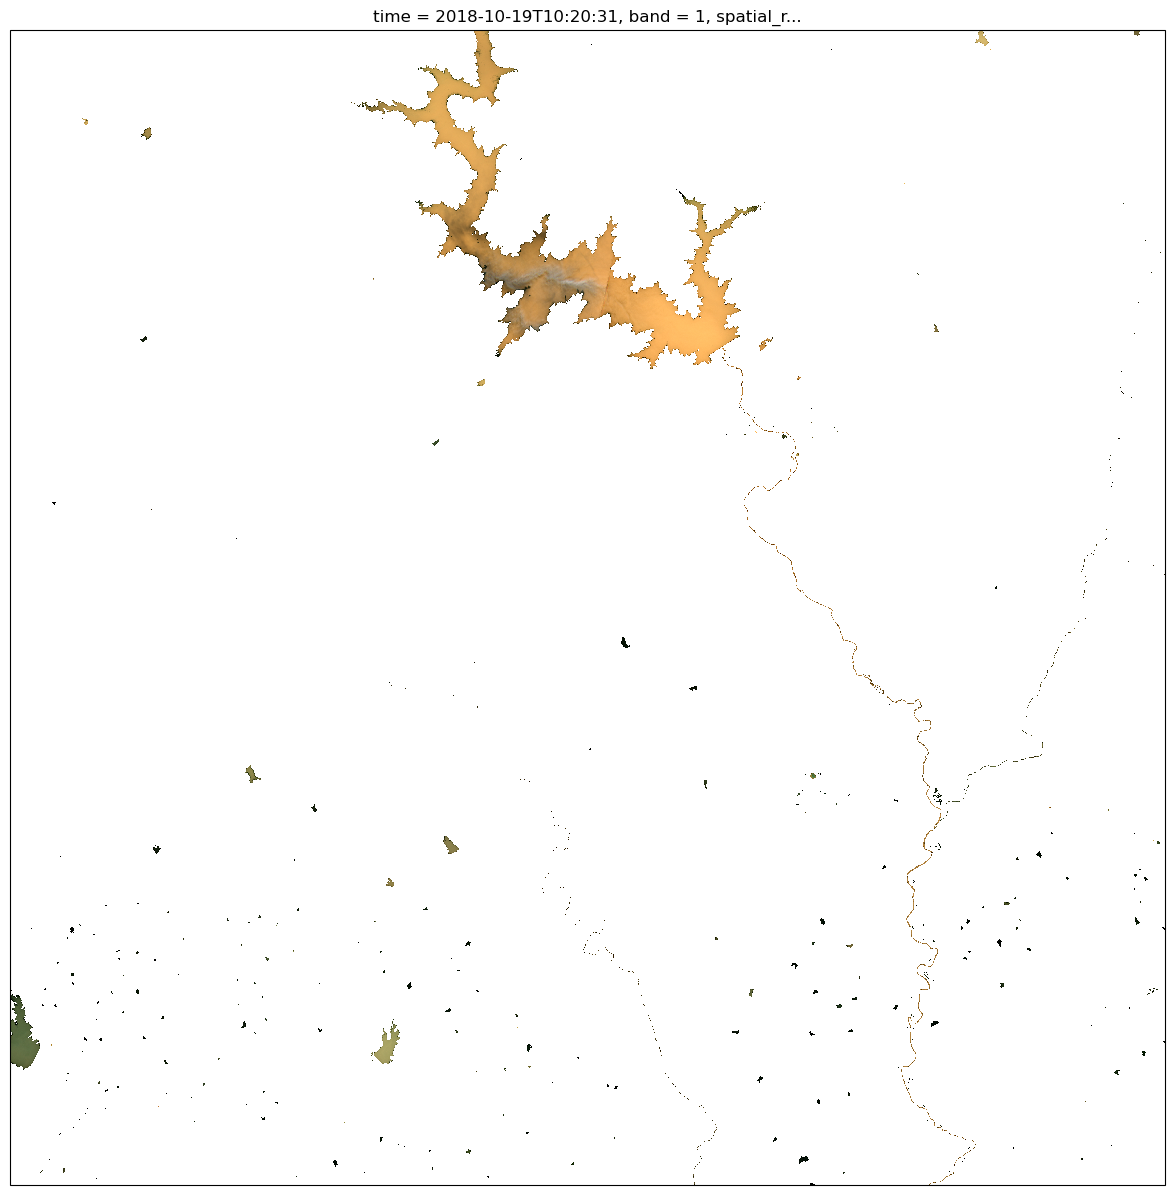

In [6]:
str_epsg = str(process_.l2a.l2_prod.rio.crs)
zone = str_epsg[-2:]
is_south = str_epsg[2] == 7
proj = ccrs.UTM(zone, is_south)

plt.figure(figsize=(15,15))
process_.l2a.l2_prod.Rrs.sel(wl=[665,560,490]).plot.imshow(rgb='wl', robust=True,subplot_kws=dict(projection=proj))


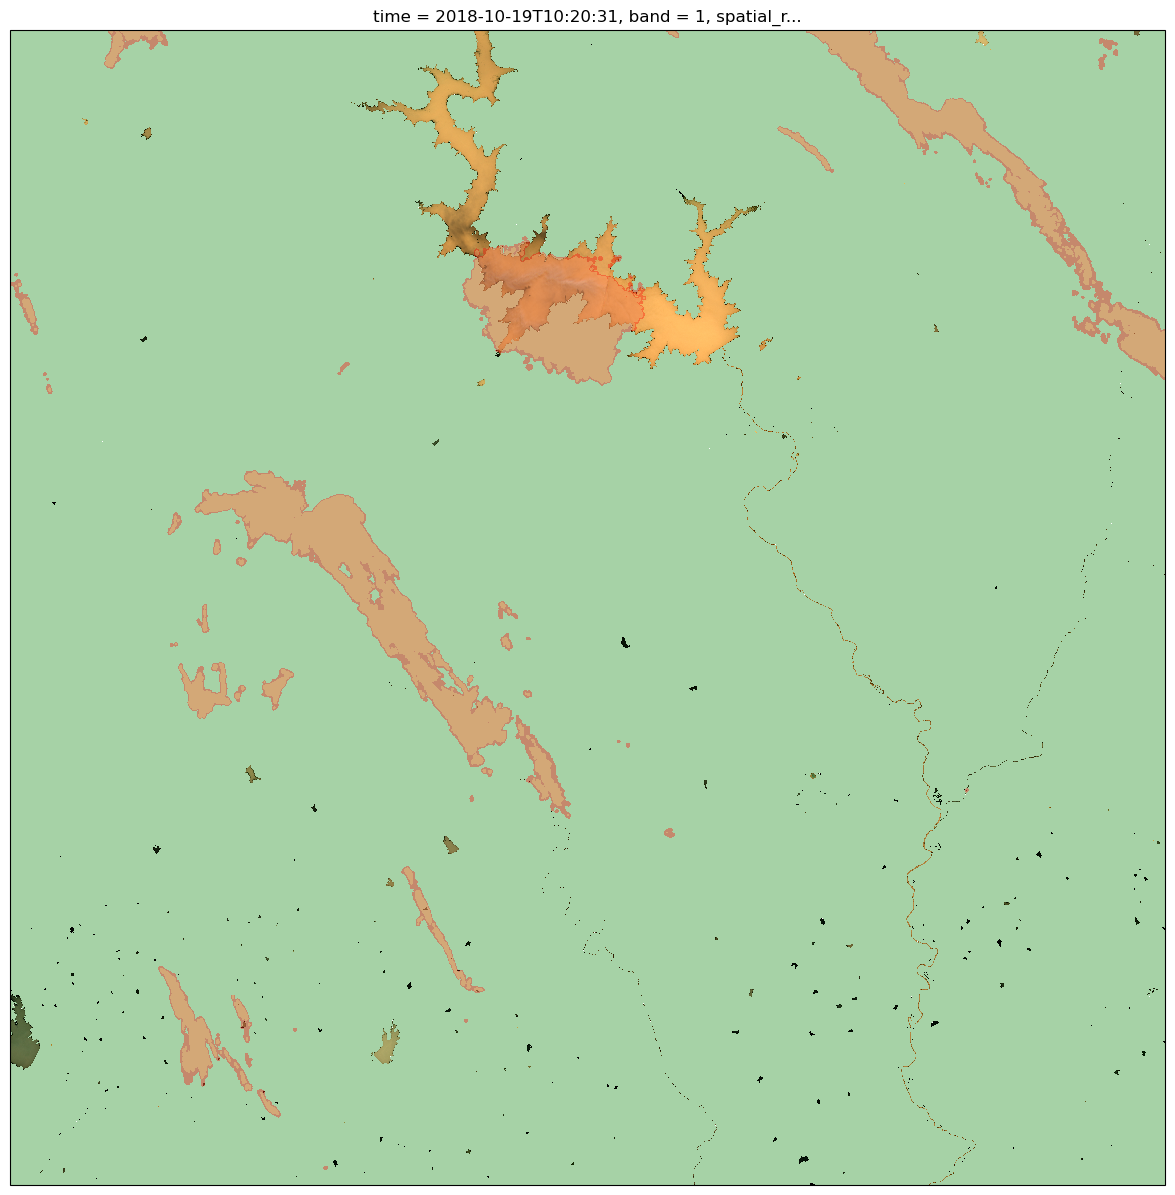

In [7]:
raster = process_.l2a.l2_prod
str_epsg = str(process_.l2a.l2_prod.rio.crs)
zone = str_epsg[-2:]
is_south = str_epsg[2] == 7
proj = ccrs.UTM(zone, is_south)


alpha=0.35
bcmap = mpl.colors.ListedColormap([(0,0,0,0),'khaki'])
bcmap2 = mpl.colors.ListedColormap([(0,0,0,0),'red'])

plt.figure(figsize=(15,15))
raster.Rrs.sel(wl=[665,560,490]).plot.imshow(rgb='wl', robust=True,subplot_kws=dict(projection=proj))

# get landmask (third bit)
bcmap = mpl.colors.ListedColormap([(0,0,0,0),'green'])
flag_value = 1 << 3
((raster.flags_l1c & flag_value) != 0).plot.imshow(cmap=bcmap,alpha=alpha,add_colorbar=False)
# get cloud p06 (second bit)
bcmap = mpl.colors.ListedColormap([(0,0,0,0),'red'])
flag_value = int('0010', 2)
((raster.flags_l1c & flag_value) != 0).plot.imshow(cmap=bcmap,alpha=alpha,add_colorbar=False)
# get cloud p08 (third bit)
bcmap = mpl.colors.ListedColormap([(0,0,0,0),'khaki'])
flag_value = int('0100', 2)
((raster.flags_l1c & flag_value) != 0).plot.imshow(cmap=bcmap,alpha=alpha,add_colorbar=False)

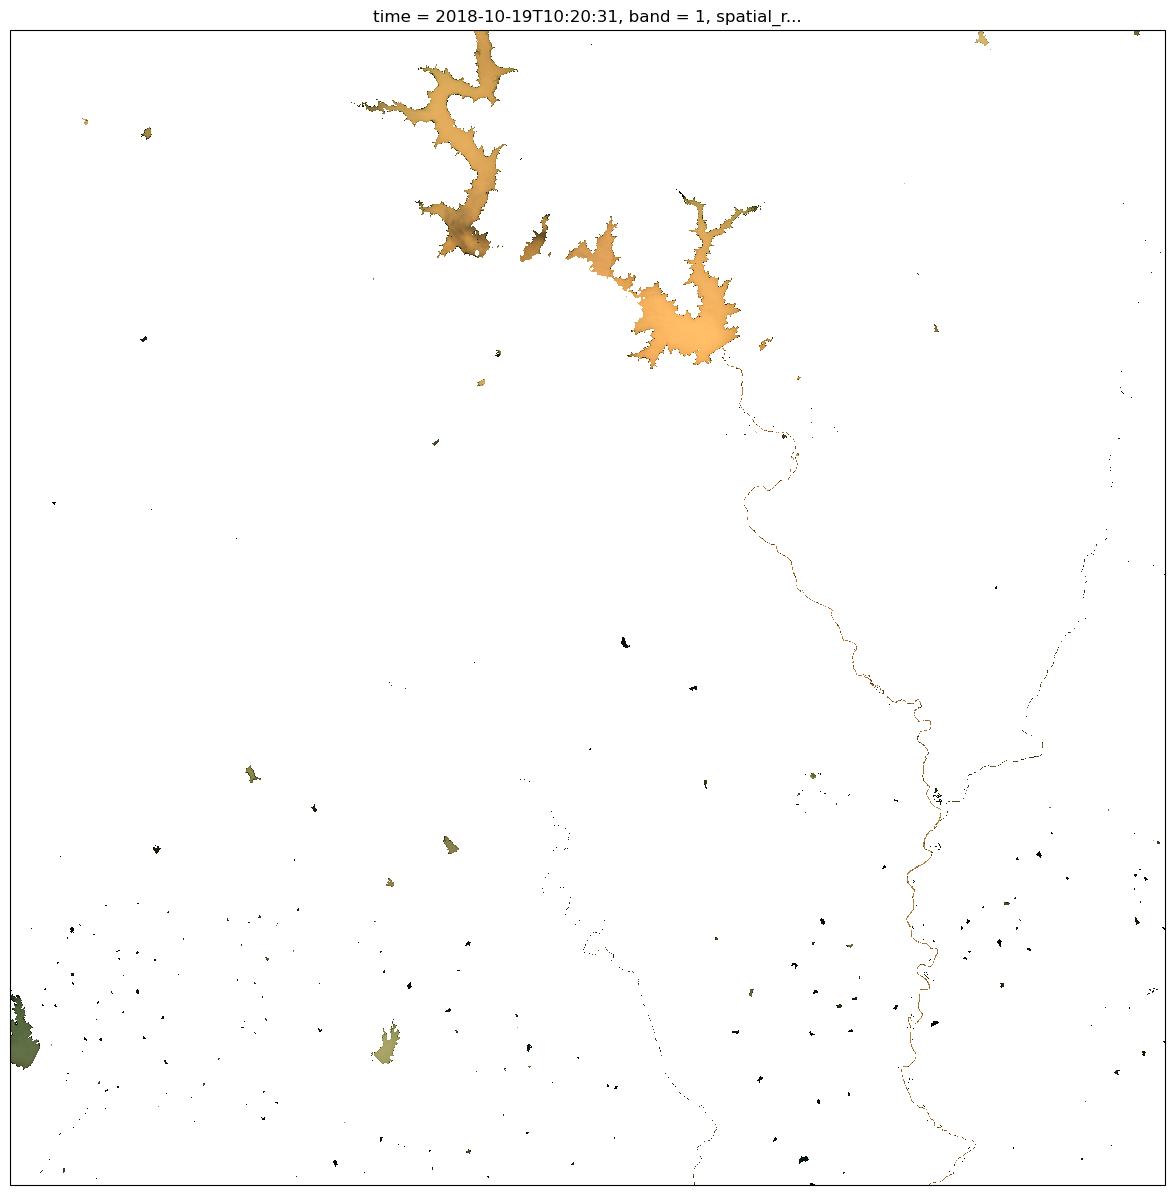

In [8]:
# get cloud p08 (third bit)

flag_value = 1 << 2
mask = ((raster.flags_l1c & flag_value) != 0)
Rrs = process_.l2a.l2_prod.Rrs.where(~mask)

plt.figure(figsize=(15,15))
#dem_attrs.shaded.plot.imshow(robust=True,subplot_kws=dict(projection=proj),cmap=plt.cm.Greys_r,cbar_kwargs={'shrink':0.4})
Rrs.sel(wl=[665,560,490]).plot.imshow(rgb='wl', robust=True,subplot_kws=dict(projection=proj))